In [1]:
import logging
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import random
import sys
from dataclasses import dataclass, field
from typing import Optional

import datasets
import numpy as np
from datasets import load_dataset, load_metric

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from modeling_distill import BertForDistillSequenceClassification
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version
from transformers.utils.versions import require_version

from scipy.special import softmax


In [10]:
def get_labels(model):
# model = "mrpc/baseline_base_seed0_BS64_lr9e-5_epoch3/predict_results_mrpc.txt"

    model_file = open(model,'r')
    model_labels = [line.split("\t")[-1].strip() for line in model_file][1:]
    model_labels = [1 if t=="equivalent" else 0 for t in model_labels]
    return model_labels

In [12]:
def ensemble(l):
    ret = []
    
    for i in range(len(l[0])):
        vot = 0
        for j in range(len(l)):
            vot += l[j][i]
        if vot > 2:
            ret.append(1)
        else:
            ret.append(0)
    return ret

In [20]:
l = []
for m in [1,2,3,4,5]:
    l.append(get_labels("mrpc/baseline_large_seed{}_BS32_lr3e-5_epoch3/predict_results_mrpc.txt".format(m)))
    

In [21]:
ens_ret = ensemble(l)

In [22]:
!mkdir mrpc/baseline_large_ensemble/

In [23]:
f = open("mrpc/baseline_large_ensemble/predict_results_mrpc.txt",'w')
f.write("index\tprediction\n")
for i, x in enumerate(ens_ret):
    if x == 1:
        f.write(str(i) + "\tequivalent\n")
    else:
        f.write(str(i) + "\tnot_equivalent\n")

f.close()

In [2]:
task = "mrpc"
old_model = "mrpc/base_seed0_BS32_lr3e-5_epoch4"
# old_model = "qqp/baseline_base_seed0_BS64_lr9e-5_epoch5"
config = AutoConfig.from_pretrained(
    old_model,
    num_labels=2,
    finetuning_task=task
)
tokenizer = AutoTokenizer.from_pretrained(
    old_model,
)
tea_model = AutoModelForSequenceClassification.from_pretrained(
    old_model,
    config=config,
)
trainer = Trainer(
    model=tea_model,
    tokenizer=tokenizer,
)


In [3]:

task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}


# Preprocessing the raw_datasets

sentence1_key, sentence2_key = "sentence1", "sentence2"
# sentence1_key, sentence2_key = "question1", "question2"



def preprocess_function(examples):
    # Tokenize the texts
#     print(examples)
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, padding=True, max_length=128, truncation=True)

    # Map labels to IDs (not necessary for GLUE tasks)
#     if label_to_id is not None and "label" in examples:
#         result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
    return result

raw_datasets = load_dataset("glue", task)
raw_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset",
)
    


train_dataset = raw_datasets["train"]

eval_dataset = raw_datasets["validation"]

predict_dataset = raw_datasets["test"]

label_list = raw_datasets["train"].features["label"].names



Reusing dataset glue (/home/ec2-user/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-ea916b755ec3b506.arrow
Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-12ded0ffec826fdd.arrow
Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-3f0b6fbcfadb607d.arrow


In [4]:
old_output = trainer.predict(raw_datasets["validation"], metric_key_prefix="predict")
old_prob = softmax(old_output.predictions, axis=1)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, sentence1, sentence2.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8


In [5]:
from modeling_BFSC_2l import BertForGatedSequenceClassification

seed = 3
# new_model = "qqp/baseline_large_seed{}_BS32_lr3e-5_epoch5".format(seed)
new_model = "gated_v4/mrpc_new/gatedfinal_large_seed{}_BS12_lr3e-6_epoch3_3".format(seed)
config = AutoConfig.from_pretrained(
    new_model,
    num_labels=2,
    finetuning_task=task,
#     output_hidden_states=True
)
tokenizer = AutoTokenizer.from_pretrained(
    new_model,
)
model = BertForGatedSequenceClassification.from_pretrained(
    new_model,
    teacher_model=tea_model,
    config=config,
)
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
)


output = trainer.predict(raw_datasets["validation"], metric_key_prefix="eval")
new_prob = softmax(output.predictions, axis=1)

loading configuration file gated_v4/mrpc_new/gatedfinal_large_seed3_BS12_lr3e-6_epoch3_3/config.json
Model config BertConfig {
  "_name_or_path": "gated_v4/mrpc_new/gatedinit_large_seed3_BS12_lr3e-6_initepoch3",
  "architectures": [
    "BertForGatedSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "mrpc",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": 0,
    "1": 1
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "0": 0,
    "1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_

## Ensemble Old & New:

In [55]:
import os
os.mkdir("mrpc/old_new_base_seed{}".format(seed))

FileExistsError: [Errno 17] File exists: 'mrpc/old_new_base_seed3'

In [48]:

predictions = np.argmax(new_prob + old_prob, axis=1)
with open("mrpc/old_new_base_seed{}/predict_results_mrpc.txt".format(seed), "w") as writer:
#     logger.info(f"***** Predict results {task} *****")
    writer.write("index\tprediction\n")
    for index, item in enumerate(predictions):
#         if is_regression:
#             writer.write(f"{index}\t{item:3.3f}\n")
#         else:
        item = label_list[item]
        writer.write(f"{index}\t{item}\n")

In [6]:
from torch.utils.data import DataLoader, Dataset, IterableDataset, RandomSampler, SequentialSampler
from transformers.data.data_collator import default_data_collator, DataCollatorWithPadding
test_dataloader = DataLoader(
    raw_datasets["validation"],
    collate_fn=default_data_collator,
    batch_size=8,
#     collate_fn=DataCollatorWithPadding(tokenizer),
#                 num_workers=self.args.dataloader_num_workers,
#                 pin_memory=self.args.dataloader_pin_memory,
)



In [7]:
import torch
outputs = []
model.eval()
labels = []
for x in test_dataloader:
    y = {
        "input_ids": x["input_ids"].to("cuda"),
        "attention_mask": x["attention_mask"].to("cuda"),
        "token_type_ids": x["token_type_ids"].to("cuda"),
        "labels": x["labels"].to("cuda"),
        }
    labels.append(x["labels"])
    with torch.no_grad():
        output = model(
            input_ids=y["input_ids"],
            attention_mask=y["attention_mask"],
            token_type_ids=y["token_type_ids"],
            labels=y["labels"],
            output_hidden_states=True,
            return_dict=False
        )

#     print(output[3])
#     input()
    del y
    torch.cuda.empty_cache()
    outputs.append(output[3])

In [8]:
gates = []
for out in outputs:
    gates += [x[0] for x in out.tolist()]
len(gates)


408

In [9]:
ls = []
for l in labels:
    ls += [x for x in l.tolist()]
# ls

In [10]:
old_labels = []
for p in old_prob:
#     print(p)
    if p[0] >= p[1]:
        old_labels.append(0)
    else:
         old_labels.append(1)
# old_labels

In [16]:
# old_output
# output.predictions
# (n -  (1-g) * o ) / g = on +
gates = np.array(gates)
old_l = np.transpose(old_output.predictions)
ot = (1 - gates) * old_l
m = np.transpose(output.predictions) - ot
new_logits = m / gates
new_logits = np.transpose(new_logits)


In [18]:
old_labels == orig_new_labels

False

In [17]:
orig_new_labels = []
for p in new_logits:
#     print(p)
    if p[0] >= p[1]:
        orig_new_labels.append(0)
    else:
        orig_new_labels.append(1)
# orig_new_labels

In [13]:
output = trainer.predict(raw_datasets["validation"], metric_key_prefix="eval")
new_prob = softmax(output.predictions, axis=1)
new_labels = []
for p in new_prob:
#     print(p)
    if p[0] >= p[1]:
        new_labels.append(0)
    else:
         new_labels.append(1)
# new_labels

The following columns in the test set  don't have a corresponding argument in `BertForGatedSequenceClassification.forward` and have been ignored: idx, sentence1, sentence2.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8


In [52]:
total = len(ls)
pf = []
nf = []
pnf = []
nnf = []
fixed_nf = []
fixed_f = []
for i, l in enumerate(ls):
    if l == orig_new_labels[i]:
        if l == old_labels[i]:
            pnf.append(i)
        else:
            pf.append(i)
    else:
        if new_labels[i] == l:
            fixed_f.append(i)
        if l == old_labels[i]:
            nf.append(i)
            if new_labels[i] == l:
                fixed_nf.append(i)
        else:
            nnf.append(i)

In [53]:
fixed_f

[338]

Text(0, 0.5, 'Counts in Dev set')

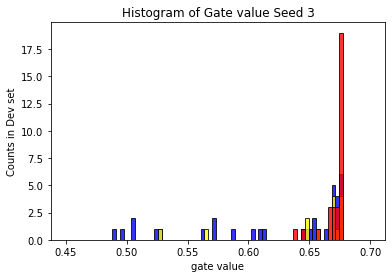

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# bins = range(0.4, 0.7, 0.05)
bins = np.linspace(0.45, 0.7, 80)
# matplotlib histogram
gates_pf = [gates[x] for x in pf]
gates_nf = [gates[x] for x in nf]
gates_pnf = [gates[x] for x in pnf]
gates_nnf = [gates[x] for x in nnf]


plt.hist(gates_pf, color = 'blue', edgecolor = 'black',bins=bins, alpha=0.8, label="PF")
plt.hist(gates_nf, color = 'yellow', edgecolor = 'black',bins=bins, alpha=0.8, label="NF")
# plt.hist(gates_pnf, color = 'green', edgecolor = 'black', bins=bins)
plt.hist(gates_nnf, color = 'red', edgecolor = 'black',bins=bins, alpha=0.8, label="NNF")

# seaborn histogram
# sns.distplot(gates, hist=True, kde=False, 
#              bins=bins, color = 'blue',
#              hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Gate value Seed {}'.format(seed))
plt.xlabel('gate value')
plt.ylabel('Counts in Dev set')

